## Computing Cross Sections with Different Broadening Parameters

In this tutorial, we create a cross section for a molecule using different broadening coefficients.

We again choose the CO Li2015 line list from ExoMol. We compute the cross section using ExoMol's given $\rm{H_2}$-$\rm{He}$ broadening files and also using 2 custom broadening methods. One of these custom broadening methods has a constant relationship between the pressure broadening Lorentzian half-width-half-maximum and the lower state rotational angular momentum quantum number (i.e. $\gamma_{L}(J) =$ constant) and the other has a linearly decreasing relationship. 

We strongly recommend reading the [Quick Start](https://cthulhu-xsec.readthedocs.io/en/latest/content/notebooks/quick_start.html) guide if you have not done so yet.

### Download CO line list and $\rm{H_2}$-$\rm{He}$ broadening files from ExoMol

By now you should be a seasoned cultist of the Old One's family, so you know what to do. 

But this time, note that the `summon` function you've been using all this time has also been downloading pressure broadening files from ExoMol. In the input folder, you will see files for $\rm{H_2}$, $\rm{He}$, and air broadening (`H2.broad`, `He.broad`, and `air.broad`).

In [1]:
from Cthulhu.core import summon

species = 'CO'
database = 'ExoMol'

# Download CO line list
summon(database = database, species = species)  


 ***** Downloading requested data from ExoMol. You have chosen the following parameters: ***** 

Molecule: CO 
Isotopologue: 12C-16O 
Line List: Li2015

Starting by downloading the .broad, .pf, and .states files...
Fetched the broadening coefficients, partition functions, and energy levels.
Now downloading the Li2015 line list...



100%|██████████| 1.40M/1.40M [00:00<00:00, 1.50MiB/s]



Converting this .trans file to HDF to save storage space...
This file took 0.3 seconds to reformat to HDF.



100%|██████████| 63.5k/63.5k [00:00<00:00, 290kiB/s]


Converting this .trans file to HDF to save storage space...
This file took 0.1 seconds to reformat to HDF.

Line list ready.



### Cthulhu's Default Pressure Broadening

When you don't specify a pressure broadening prescription (as we haven't until now), `Cthulhu` will use a default treatment for pressure broadening. The default is as follows:

* ExoMol: $\rm{H_2}$-$\rm{He}$ pressure broadening with 85% $\rm{H_2}$ and 15% $\rm{He}$ (via the downloaded `H2.broad` and `He.broad` files).
* HITRAN / HITEMP: air broadening using a $J$-dependent set of broadening parameters computed by averaging over other quantum numbers in the HITRAN `.par` files.
* VALD: a collisional approximation for $\rm{H_2}$-$\rm{He}$ pressure broadening with 85% $\rm{H_2}$ and 15% $\rm{He}$.

You can of course always specify a different treatment, as we will see below.

### Adding custom broadening files

Now, let's create our custom broadening file and add them to the directory. To do this, we create numpy arrays for $J$, $\gamma_{L}(J)$, and $n_{L}$ and write them to a file.

In [2]:
import numpy as np

# Populate arrays
J = np.linspace(0, 80, num = 81)    # Rotational quantum numbers from J = 0 to J = 80
gamma_L_0 = 0.07 * np.ones(81)      # Lorentzian HWHM is 0.07 for all J
n_L = 0.5 * np.ones(81)             # Temperature exponent is 0.5 for all J

Now that we have defined the necessary variables, we call the `write_broadening_file` function to write these arrays to a file and place it in the correct folder. This function requires at least 5 parameters, the name of the file (`broadening_file`), the data to be written (`data`), the 'input' directory (`input_dir`), the name of the molecule (`species`), and the database (`database`).

The 3 arrays we just created should be combined into 1 array prior to calling the `write_broadening_file` function. This can be done using `np.stack`, as shown below. Make sure to keep the same order of the arrays (`J` then `gamma_L_0` then `n_L`).

The variable `input_dir` should be set to `./input/` unless you have edited the file structure Cthulhu automatically creates.

In [3]:
from Cthulhu.broadening import write_broadening_file

data = np.stack((J, gamma_L_0, n_L))  # Combine arrays into 1 array to pass into write_broadening_file function

broadening_file = 'constant.broad'    # Name of the file we will save data to

input_dir = './input/'                # Top level input directory that contains line list data for all species

# Create broadening file
write_broadening_file(broadening_file, data, input_dir, species, database) 

Great, we have added our first custom broadening file!

Now let's do the same for a broadening file where $\gamma_{L}(J)$ decreases linearly for increasing $J$ until a cutoff at $J = 20$. The steps are the same, except `gamma_L_0` will be different. For simplicity, we just redefine this variable, as well as the name of the broadening file, and keep everything else the same. 

In [4]:
gamma_L_0_beginning = np.linspace(start = 0.07, stop = 0.06, num = 21)         # 20 evenly spaced numbers from 0.07 to 0.06
gamma_L_0_end = 0.06 * np.ones(60)                                             # Lorentzian HWHM is 0.06 for all J after J = 20
gamma_L_0 = np.concatenate((gamma_L_0_beginning, gamma_L_0_end), axis = None)  # Combine both arrays for full Lorenztian HWHM

data = np.stack((J, gamma_L_0, n_L))  # Combine arrays

broadening_file = 'linear.broad'    # Name of the file we will save data to

input_dir = './input/'              # Top level input directory that contains line list data for all species

# Create broadening file
write_broadening_file(broadening_file, data, input_dir, species, database) 

### Computing and Plotting Cross Section
Now we are ready to compute the cross section. We do this in the usual way. The only parameter that changes is `broad_type` and `broadening_file`. If we set `broad_type` to 'fixed' a constant relationship between $J$ and $\gamma_{L}(J)$ is assumed. If we set `broad_type` to 'custom', the custom.broad file we added is used. If we assign no value to `broad_type` (or assign it to 'default'), Cthulhu defaults to using the broadening parameters already downloaded with the line list. In the case for CO, the default is H2-He broadening (as is often the case with ExoMol line lists). 

Since we created 2 custom broadening files, we set `broad_type` to 'custom' in both calls to `compute_cross_section`. We also need to pass in the name of the broadening file in both instances, which you will recall were 'constant.broad' and 'linear.broad'. As an aside, you can also set `broad_type` = 'fixed' for the constant $\gamma_{L}(J)$ file we created.

In [5]:
from Cthulhu.core import compute_cross_section

P = 1.0                        # Pressure in bars
T = 1000.0                     # Temperature in Kelvin
input_directory = './input/'   # Top level directory containing line lists

# Default H2-He pressure broadening
compute_cross_section(species = species, database = database, temperature = T, 
                      pressure = P, input_dir = input_directory, 
                      broad_type = 'default',
                      )

# Constant pressure broadening
compute_cross_section(species = species, database = database, temperature = T, 
                      pressure = P, input_dir = input_directory, 
                      broad_type = 'custom', 
                      broadening_file = 'constant.broad',
                     )

# Linear in J pressure broadening
compute_cross_section(species = species, database = database, temperature = T,
                      pressure = P, input_dir = input_directory, 
                      broad_type = 'custom', 
                      broadening_file = 'linear.broad',
                      )

Beginning cross-section computations...
Loading ExoMol format
Loading partition function
Pre-computing Voigt profiles...
Voigt profiles computed in 5.0385457550000865 s
Pre-computation steps complete
Generating cross section for CO at P = 1.0 bar, T = 1000.0 K
Computing transitions from E2.h5 | 0.0% complete
Completed 6474 transitions in 1.8249874909961363 s
Computing transitions from Li2015.h5 | 50.0% complete
Completed 125496 transitions in 1.182199076996767 s
Calculation complete!
Completed 131970 transitions in 3.008382435000385 s

Total runtime: 11.12400327999785 s
Beginning cross-section computations...
Loading ExoMol format
Loading partition function
Pre-computing Voigt profiles...
Voigt profiles computed in 4.533660020002571 s
Pre-computation steps complete
Generating cross section for CO at P = 1.0 bar, T = 1000.0 K
Computing transitions from E2.h5 | 0.0% complete
Completed 6474 transitions in 0.07487936400139006 s
Computing transitions from Li2015.h5 | 50.0% complete
Complete

Now we are able to plot the cross section. We need to first read the cross section files and add the cross sections to a collection. 

In [6]:
from Cthulhu.misc import read_cross_section_file, cross_section_collection

# Read in the cross sections we just computed
nu, sigma = read_cross_section_file(species = species, database = database,
                                    filename = 'CO_T1000.0K_log_P0.0_H2-He_sigma.txt')
nu2, sigma2 = read_cross_section_file(species = species, database = database,
                                      filename = 'CO_T1000.0K_log_P0.0_custom_constant_sigma.txt')
nu3, sigma3 = read_cross_section_file(species = species, database = database, 
                                      filename = 'CO_T1000.0K_log_P0.0_custom_linear_sigma.txt')

# Generate an empty collection object for plotting
cross_sections = []

# Add first cross section to collection
cross_sections = cross_section_collection(new_x = nu, new_y = sigma, collection = cross_sections)  

# Add second cross section to collection
cross_sections = cross_section_collection(new_x = nu2, new_y = sigma2, collection = cross_sections) 

# Add third cross section to collection
cross_sections = cross_section_collection(new_x = nu3, new_y = sigma3, collection = cross_sections) 

And finally we plot the results.

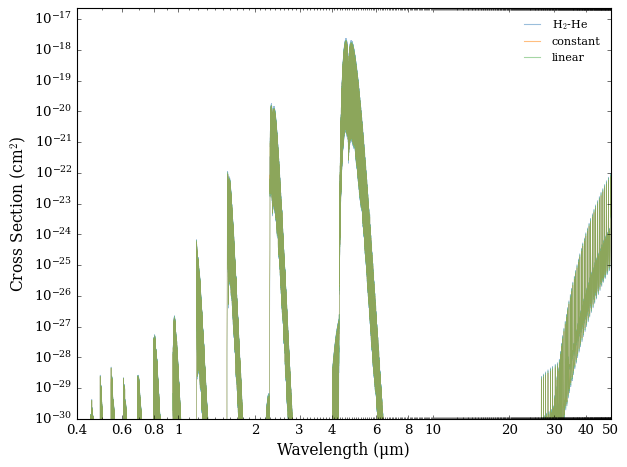

In [7]:
from Cthulhu.plot import plot_cross_section

plot_cross_section(collection = cross_sections, 
                   labels = ['H$_2$-He', 'constant', 'linear'], 
                   filename = 'Different_Broadening_Types_for_CO',
                   y_min = 1.0e-30,
                   )

Whilst at first glance it may look like all three cross sections are the same, pressure broadening differences are easier to see when you zoom in on a narrow region.

Let's examine the region from 4.26 μm and 4.27 μm to show the differences more clearly.

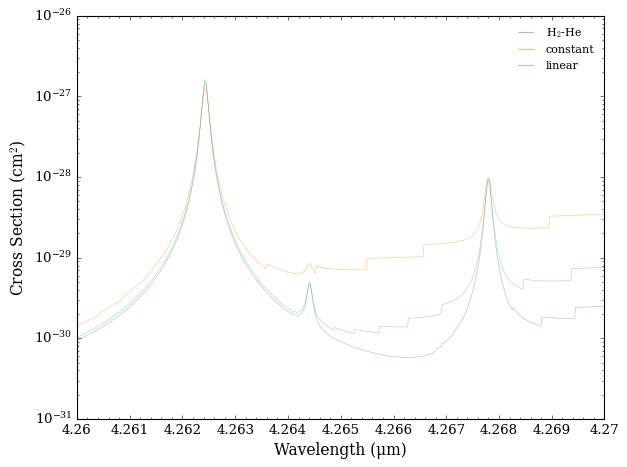

In [9]:
plot_cross_section(collection = cross_sections,
                   labels = ['H$_2$-He', 'constant', 'linear'], 
                   filename = 'Different_Broadening_Types_for_CO_Zoomed',
                   x_min = 4.26, x_max = 4.27,
                   y_min = 1e-31, y_max = 1.0e-26,
                   )